In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import sys
import glob
import re
import pickle
import random

import wave
import librosa as lb
import librosa.display as lbd
from python_speech_features import *
import soundfile as sf
import io
from IPython.display import Audio

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import ast

2025-07-21 23:00:13.497692: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 23:00:13.498458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 23:00:13.502532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 23:00:13.513793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753119013.533707    2700 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753119013.53

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cpu


In [5]:
df_bdown = pd.read_csv('audio_balanced_downsampled.csv')
df_bdown.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript,Features
0,467,male,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 0.28526664 0.09967513 0.00799948 0.4890...
1,337,female,1,10,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-9.22581181e-02 1.32208377e-01 -4.22364444...
2,469,female,0,3,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[ 2.01293193e-02 1.62733659e-01 7.91895017...
3,376,female,1,12,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.2775235 0.07668287 -0.00362719 -0.1866...
4,359,male,1,13,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,[[[-0.06512055 -0.02693447 0.11681422 0.2453...


In [6]:
print("Number of samples in balanced downsampled dataset:", len(df_bdown))  

Number of samples in balanced downsampled dataset: 86


In [7]:
print(type(df_bdown['Features'].iloc[0]))
print(df_bdown['Features'].iloc[0])

<class 'str'>
[[[ 0.28526664  0.09967513  0.00799948  0.48905542  0.12127198
    0.1659826  -0.17269708  0.54367805 -0.19091344  0.16860096
   -0.00211724 -0.01013682  0.12781774  0.15260343  0.15389904
   -0.21124788 -0.32632914  0.23711209  0.36171004  0.30934563
    0.11415772 -0.10290753 -0.34086257  0.34532258 -0.6579446
    0.07291698 -0.2297345   0.35261345 -0.050881   -0.17739771
   -0.40436238  0.4246573  -0.00125622  0.13358691 -0.05047036
   -0.00332822  0.41809657 -0.21010529  0.11331427 -0.00678972
    0.28606018 -0.3902071   0.20886554 -0.04670826  0.04922586
   -0.0953049   0.14358523 -0.07969916 -0.39854673 -0.23556328
    0.47426412  0.10938217 -0.46012586 -0.07168368 -0.0155896
    0.16015914  0.11619328  0.18813565 -0.02719881 -0.12332885
    0.0246286  -0.05143805 -0.04809962 -0.03832301 -0.20283484
    0.15670893 -0.0173712  -0.19370753 -0.32990655  0.10483871
    0.14486666 -0.27059183 -0.2064145  -0.13155659  0.01104231
    0.2332998   0.35973024 -0.23991074 -0.1

In [8]:
df_bdown['Features'] = df_bdown['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))

In [9]:

# print df_bdown['Features'][0] shape
feat = df_bdown['Features'][0]
feat = feat.reshape(1, -1)  # Reshape to 2D array for display
feat = feat.reshape(16, 16)
print("Shape of features in df_bdown:", feat.shape)

# initialize X_d
X_d = np.zeros((len(df_bdown), 16, 16))  # Initialize with zeros

i = 0

for f in df_bdown['Features']:    
    f = f.reshape(16, 16)  # Reshape to 2D array for display
    if f.shape != (16, 16):
        print("Shape mismatch:", f.shape)
    X_d[i] = f
    i += 1
    
    
# X_d = np.stack(df_bdown['Features'].values)
print("X_d shape before reshape:", X_d.shape)
# X_d = X_d.reshape(-1, 1, 256)
X_d = X_d.reshape(-1, 16, 16)
y_d = df_bdown['PHQ_Binary'].values 

Shape of features in df_bdown: (16, 16)
X_d shape before reshape: (86, 16, 16)


In [10]:
Xd_train, Xd_test, yd_train, yd_test = train_test_split(X_d, y_d, test_size=0.2, random_state=44)
print("Train and Test Split for Downsampled:" f"{Xd_train.shape}, {Xd_test.shape}, {yd_train.shape}, {yd_test.shape}")

Train and Test Split for Downsampled:(68, 16, 16), (18, 16, 16), (68,), (18,)


In [11]:
model = Sequential()
model.add(GRU(32, input_shape=(16, 16), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-07-21 23:00:18.832447: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,345 (20.88 KB)

 Trainable params: 5,345 (20.88 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")    
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    

In [13]:
# plot graph of accuracy and loss over time in subplots
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    

Epoch 1/10


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.4777 - loss: 0.6985 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4624 - loss: 0.7004 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4965 - loss: 0.7017 - val_accuracy: 0.3889 - val_loss: 0.6936
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4792 - loss: 0.6866 - val_accuracy: 0.6111 - val_loss: 0.6931
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6414 - loss: 0.6823 - val_accuracy: 0.6111 - val_loss: 0.6929
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5440 - loss: 0.6901 - val_accuracy: 0.6111 - val_loss: 0.6928
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5546 - loss: 0.6874 - val_accuracy: 0.6111 - val_loss: 0.6928
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5549 - loss: 0.6838 - val_accuracy: 0.6111 - val_loss: 0.6929
Epoch 9/10

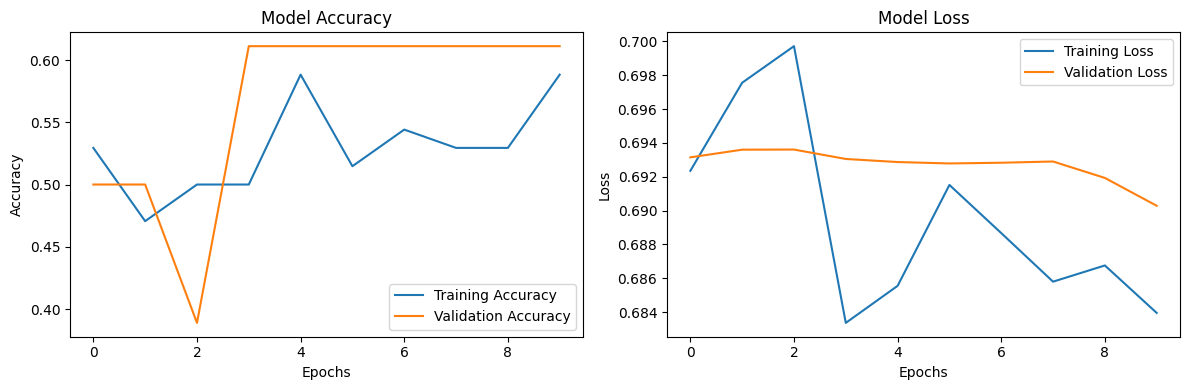

In [14]:
epochs = 10
history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=16, validation_data=(Xd_test, yd_test))
evaluate_model(model, Xd_test, yd_test)
plot_history(history)
model.save('saved_models/gru_model_d_epochs10.keras')   

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6625 - loss: 0.6706 - val_accuracy: 0.6111 - val_loss: 0.6887
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6044 - loss: 0.6719 - val_accuracy: 0.5556 - val_loss: 0.6874
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6503 - loss: 0.6778 - val_accuracy: 0.5556 - val_loss: 0.6865
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6341 - loss: 0.6754 - val_accuracy: 0.5556 - val_loss: 0.6858
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5928 - loss: 0.6713 - val_accuracy: 0.5556 - val_loss: 0.6850
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5474 - loss: 0.6875 - val_accuracy: 0.5556 - val_loss: 0.6839
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6717 - loss: 0.6623 - val_accuracy: 0.5556 - val_loss: 0.6832
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6416 - loss: 0.6774 - val_accuracy: 0.6111 - val_loss:

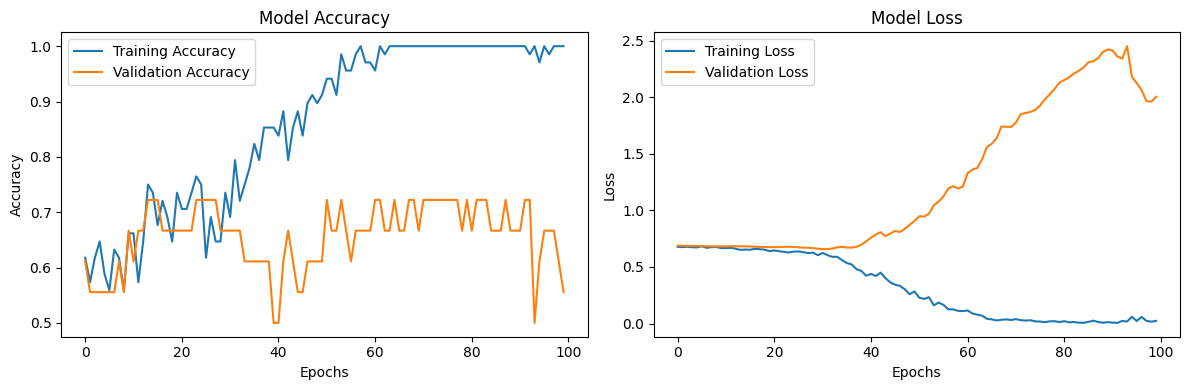

In [15]:
epochs = 100
history = model.fit(Xd_train, yd_train, epochs=epochs, batch_size=16, validation_data=(Xd_test, yd_test))
evaluate_model(model, Xd_test, yd_test)
plot_history(history)
# model.save('saved_models/gru_model_d_epochs100.keras') 

In [16]:
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
model = Sequential()
model.add(GRU(
    16,
    input_shape=(16, 16),
    return_sequences=False,
    kernel_regularizer=l2(0.001)
))
model.add(Dropout(0.5))  # Increased dropout
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,921 (7.50 KB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
print(Xd_train.shape)


(68, 16, 16)


In [19]:

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fit
history = model.fit(
    Xd_train, yd_train,
    epochs=50,
    batch_size=16,
    validation_data=(Xd_test, yd_test),
    callbacks=[early_stop]
)

Epoch 1/50


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.5384 - loss: 0.7195 - val_accuracy: 0.5000 - val_loss: 0.7316
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4878 - loss: 0.7349 - val_accuracy: 0.5000 - val_loss: 0.7305
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5671 - loss: 0.7161 - val_accuracy: 0.5000 - val_loss: 0.7293
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5575 - loss: 0.7088 - val_accuracy: 0.5000 - val_loss: 0.7287
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5255 - loss: 0.7198 - val_accuracy: 0.5000 - val_loss: 0.7282
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5113 - loss: 0.7216 - val_accuracy: 0.5000 - val_loss: 0.7271
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5156 - loss: 0.7275 - val_accuracy: 0.5000 - val_loss: 0.7262
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4933 - loss: 0.7159 - val_accuracy: 0.5000 - val_loss: 0.7252
Epoch 9/50

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Accuracy: 0.5556
Precision: 0.5000
Recall: 0.8750
F1 Score: 0.6364


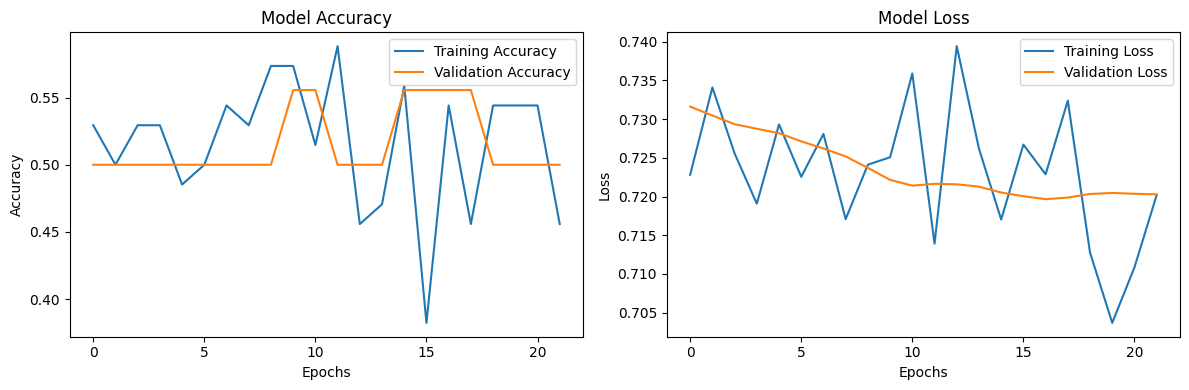

In [20]:
evaluate_model(model, Xd_test, yd_test)
plot_history(history)
